# 01: Data Exploration

Distributions, keyword frequencies, correlations, missing data


## Setup

**Imports**

In [1]:
import pickle
from pathlib import Path

import numpy as np
import pandas as pd
import networkx as nx

import matplotlib.pyplot as plt
import seaborn as sns

**Plotting Prep**

In [2]:
color_top = "slateblue"
color_recent = "lightcoral"
colors = [color_top, color_recent]

def add_grid(ax, axis="x"):
    ax.set_axisbelow(True)
    ax.grid(axis=axis,  alpha=0.5)

## Load Data

**Load and Verify**

In [3]:
def load_and_verify_graph(graph_name, graph_dir):
    """Load a graph from a gpickle file and print its summary."""
    gpickle_path = graph_dir / f"{graph_name}.gpickle"
    edges_path = graph_dir / f"{graph_name}_edges.csv"

    df_edges = pd.read_csv(edges_path)

    with open(gpickle_path, "rb") as f:
        G = pickle.load(f)

    num_core_packages = G.graph.get("num_core_packages", "N/A")

    # Print graph summary
    print(f"Graph '{graph_name}':")
    print(f"  {G.number_of_nodes():,} nodes")
    print(f"  {num_core_packages} core packages")
    print(f"  {G.number_of_edges():,} edges")
    print(f"  directed={G.is_directed()}")
    print("\nSample node metadata:")
    for node, data in list(G.nodes(data=True))[:5]:
        summary = ", ".join(f"{k}={v}" for k, v in list(data.items())[:3])
        print(f"  {node}: {summary}")
    print("\nSample edge metadata:")
    for u, v, data in list(G.edges(data=True))[:5]:
        summary = ", ".join(f"{k}={v_}" for k, v_ in data.items())
        print(f"  {u} -> {v}: {summary}")
    return G, df_edges #, df_nodes

In [4]:
GRAPH_DATA_DIR = Path("../data/graph")
GRAPH_NAME = "graph_top_n200_20250717"
G_top, df_edges_top = load_and_verify_graph(GRAPH_NAME, GRAPH_DATA_DIR)

Graph 'graph_top_n200_20250717':
  572 nodes
  200 core packages
  1,245 edges
  directed=True

Sample node metadata:
  msgpack: SourceRank=22, stars=1980, forks=227
  tqdm: SourceRank=25, stars=30041, forks=1390
  colorama: SourceRank=24, stars=3664, forks=261
  nbval: SourceRank=19, stars=443, forks=51
  pytest: SourceRank=30, stars=12841, forks=2828

Sample edge metadata:
  tqdm -> colorama: kind=runtime, optional=False
  tqdm -> nbval: kind=dev, optional=True
  tqdm -> pytest: kind=dev, optional=True
  tqdm -> pytest-asyncio: kind=dev, optional=True
  tqdm -> pytest-cov: kind=dev, optional=True


In [5]:
RECENT_GRAPH_NAME = "graph_recent_n200_20250717"
G_recent, df_edges_recent = load_and_verify_graph(RECENT_GRAPH_NAME, GRAPH_DATA_DIR)

Graph 'graph_recent_n200_20250717':
  975 nodes
  200 core packages
  2,070 edges
  directed=True

Sample node metadata:
  baseballquery: SourceRank=8, stars=3, forks=0
  numpy: SourceRank=31, stars=29827, forks=11047
  pandas: SourceRank=0, stars=0, forks=0
  pyarrow: SourceRank=26, stars=15710, forks=3773
  requests: SourceRank=32, stars=53049, forks=9501

Sample edge metadata:
  baseballquery -> numpy: kind=runtime, optional=False
  baseballquery -> pandas: kind=runtime, optional=False
  baseballquery -> pyarrow: kind=runtime, optional=False
  baseballquery -> requests: kind=runtime, optional=False
  baseballquery -> sqlalchemy: kind=runtime, optional=False


**Missing Metadata**

In [6]:
def show_nodes_with_missing_metadata(G, max_display=20):
    missing_metadata_nodes = [node for node, data in G.nodes(data=True) if data.get('missing_metadata')]

    if missing_metadata_nodes:
        print(f"Nodes with missing metadata: {len(missing_metadata_nodes):,}")
        print("-" * 40)
        for i, node in enumerate(missing_metadata_nodes[:max_display], 1):
            print(f"{i:3d}. {node}")
        if len(missing_metadata_nodes) > max_display:
            print(f"... and {len(missing_metadata_nodes) - max_display} more.")
        print("-" * 40)
    else:
        print("All nodes have complete metadata.")

print("Top packages graph:")
show_nodes_with_missing_metadata(G_top)
print()
print("Recent packages graph:")
show_nodes_with_missing_metadata(G_recent)

Top packages graph:
Nodes with missing metadata: 15
----------------------------------------
  1. ptyprocess
  2. importlib-metadata
  3. psycopg2
  4. sqlcipher3_binary
  5. pandas
  6. adbc-driver-sqlite
  7. vulture
  8. ray
  9. pathspec
 10. jupyterlite-pyodide-kernel
 11. scikit-umfpack
 12. jsonschema
 13. deprecation
 14. pendulum
 15. gitpython
----------------------------------------

Recent packages graph:
Nodes with missing metadata: 14
----------------------------------------
  1. pandas
  2. invenio-assets
  3. gitpython
  4. jsonschema
  5. arcpy
  6. importlib-metadata
  7. bashlex
  8. vulture
  9. myrihealth-serviceauth
 10. sqlalchemy-utils
 11. physaugnet
 12. basicsr
 13. augint-library
 14. ray
----------------------------------------


## Dependencies (Edges)

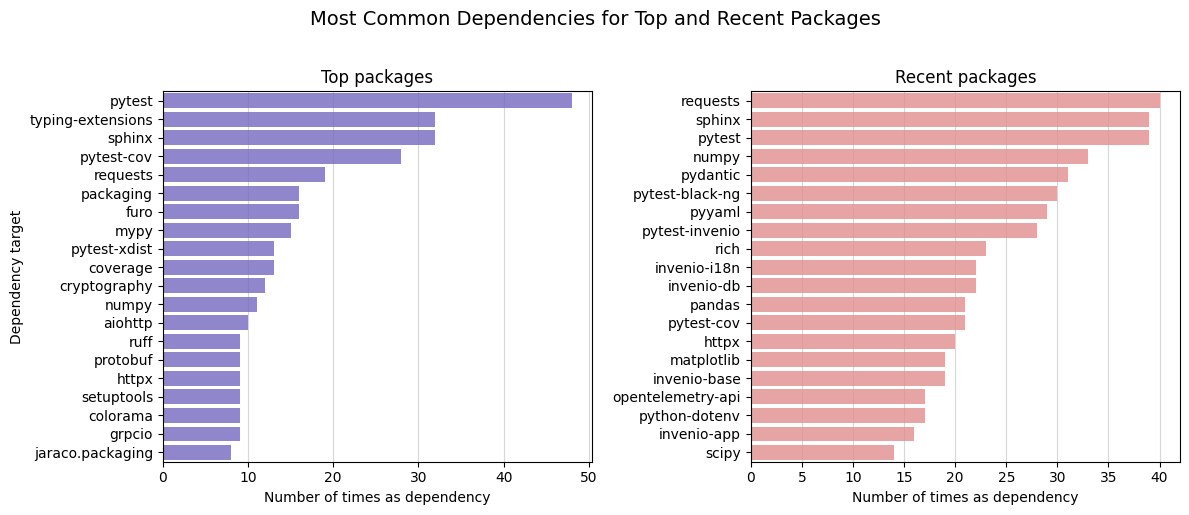

In [7]:
n = 20

top_common_targets = df_edges_top["target"].value_counts().head(n)
recent_common_targets = df_edges_recent["target"].value_counts().head(n)

fig, axes = plt.subplots(1, 2, figsize=(12, 5))

sns.barplot(
    y=top_common_targets.index,
    x=top_common_targets.values,
    ax=axes[0],
    color=color_top,
    orient="h",
    alpha=0.8
)
axes[0].set_xlabel("Number of times as dependency")
axes[0].set_ylabel("Dependency target")
axes[0].set_title("Top packages")

sns.barplot(
    y=recent_common_targets.index,
    x=recent_common_targets.values,
    ax=axes[1],
    color=color_recent,
    orient="h",
    alpha=0.8
)
axes[1].set_xlabel("Number of times as dependency")
axes[1].set_ylabel("")
axes[1].set_title("Recent packages")

for ax in axes:
    add_grid(ax)

fig.suptitle("Most Common Dependencies for Top and Recent Packages", fontsize=14, y=1.02)
plt.tight_layout()
plt.show()

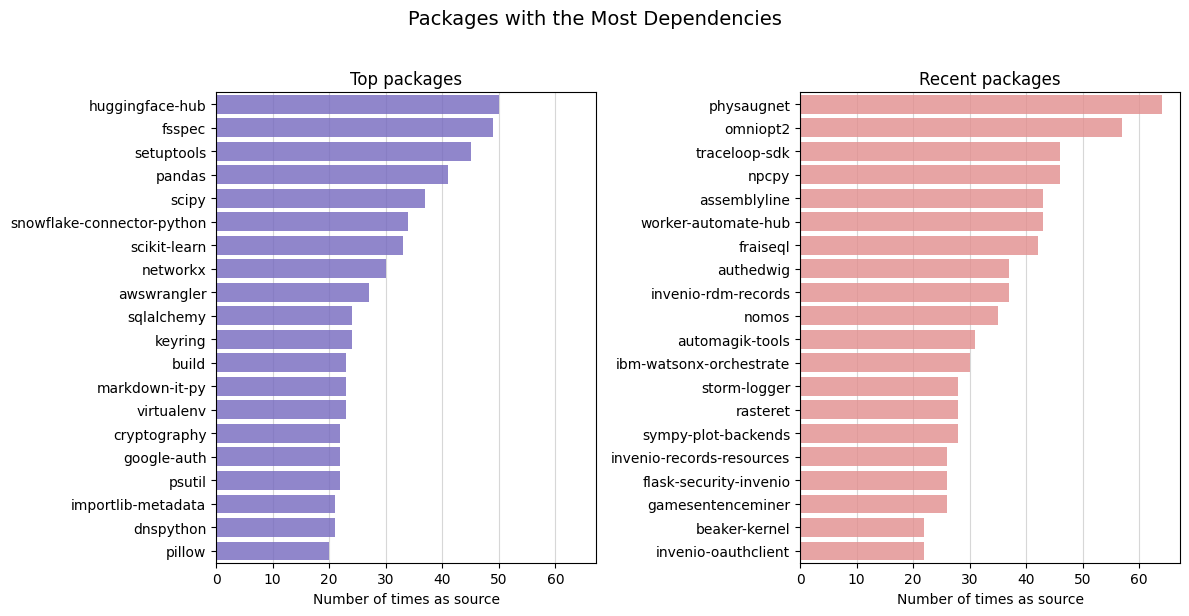

In [8]:
n = 20
top_sources = df_edges_top["source"].value_counts().head(n)
recent_sources = df_edges_recent["source"].value_counts().head(n)

fig, axes = plt.subplots(1, 2, figsize=(12, 6), sharex=True)

sns.barplot(
    y=top_sources.index,
    x=top_sources.values,
    ax=axes[0],
    color=color_top,
    orient="h",
    alpha=0.8
)
axes[0].set_xlabel("Number of times as source")
axes[0].set_ylabel(None)
axes[0].set_title("Top packages")

sns.barplot(
    y=recent_sources.index,
    x=recent_sources.values,
    ax=axes[1],
    color=color_recent,
    orient="h",
    alpha=0.8
)
axes[1].set_xlabel("Number of times as source")
axes[1].set_ylabel(None)
axes[1].set_title("Recent packages")

for ax in axes:
    add_grid(ax)

# Add grid lines
fig.suptitle("Packages with the Most Dependencies", fontsize=14, y=1.02)
plt.tight_layout()
plt.show()

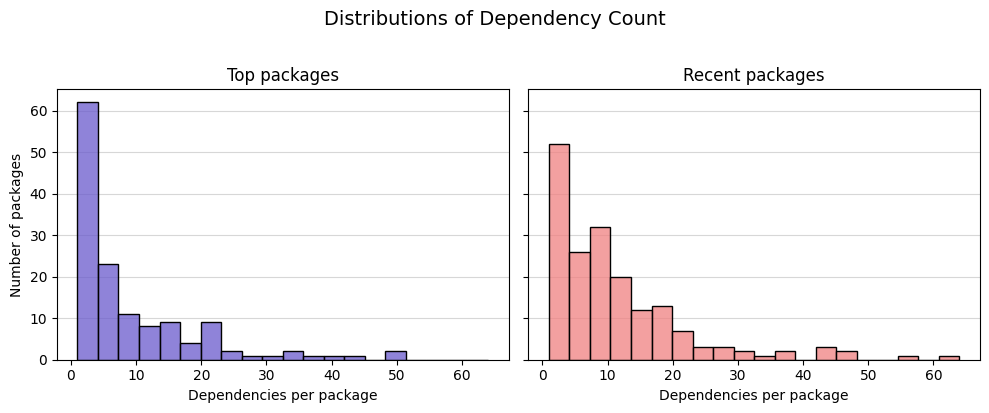

In [9]:
# Compute dependency counts for both datasets
counts_top = df_edges_top.groupby("source").size()
counts_recent = df_edges_recent.groupby("source").size()

# Find the global min and max for binning
all_counts = np.concatenate([counts_top.values, counts_recent.values])
bin_edges = np.histogram_bin_edges(all_counts, bins=20)

fig, axes = plt.subplots(1, 2, figsize=(10, 4), sharey=True, sharex=True)

for i, (counts, color, title) in enumerate([
    (counts_top, color_top, "Top packages"),
    (counts_recent, color_recent, "Recent packages")
]):
    sns.histplot(counts, bins=bin_edges, kde=False, ax=axes[i], color=color)
    axes[i].set_xlabel("Dependencies per package")
    if i == 0:
        axes[i].set_ylabel("Number of packages")
    axes[i].set_title(title)

for ax in axes:
    add_grid(ax, "y")

fig.suptitle("Distributions of Dependency Count", fontsize=14, y=1.02)
plt.tight_layout()
plt.show()

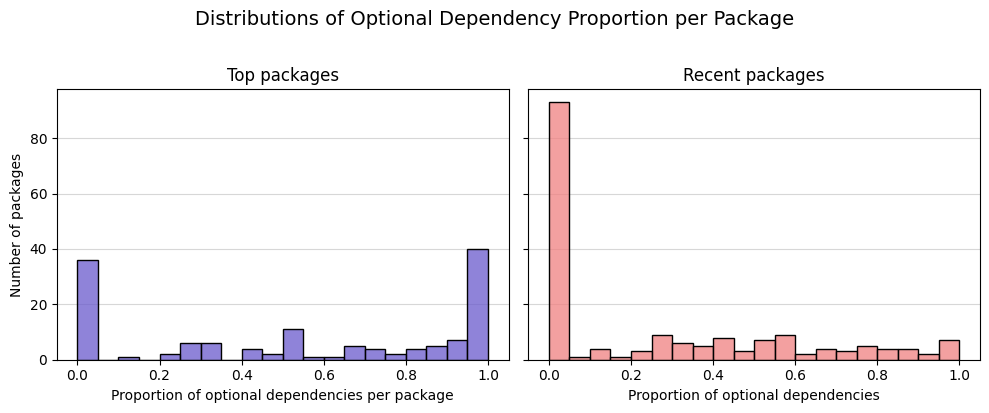

In [ ]:
# Compute proportion of optional dependencies per source package for both DataFrames
prop_top = (
    df_edges_top.groupby("source")["optional"]
    .apply(lambda x: (x == True).mean())
    .sort_values(ascending=False)
)
prop_recent = (
    df_edges_recent.groupby("source")["optional"]
    .apply(lambda x: (x == True).mean())
    .sort_values(ascending=False)
)

# Top packages
fig, axes = plt.subplots(1, 2, figsize=(10, 4), sharey=True, sharex=True)
sns.histplot(prop_top, bins=20, color=color_top, kde=False, ax=axes[0])
axes[0].set_xlabel("Proportion of optional dependencies per package")
axes[0].set_ylabel("Number of packages")
axes[0].set_title("Top packages")

# Recent packages
sns.histplot(prop_recent, bins=20, color=color_recent, kde=False, ax=axes[1])
axes[1].set_xlabel("Proportion of optional dependencies")
axes[1].set_title("Recent packages")

for ax in axes:
    add_grid(ax, "y")

fig.suptitle("Distributions of Optional Dependency Proportion per Package", fontsize=14, y=1.02)
plt.tight_layout()
plt.show()

* pytest and requests are common dependencies.
* Top packages have a more skewed distribution with fewer dependencies in general.
* Top packages are notably less likely to have no optional dependencies, and more likely to have only optional dependencies.
* fsspec stands out as having the most dependencies among the top packages at 50.
  * A high number of dependencies such as this may be anomalous for less established packages.

## Project Metadata (Nodes)

**Extract Node Features**

In [11]:
def get_core_nodes_df(G):
    return pd.DataFrame([
        {"name": node, **data}
        for node, data in G.nodes(data=True) if data.get("core")
    ])

df_nodes_top = get_core_nodes_df(G_top)
df_nodes_recent = get_core_nodes_df(G_recent)

**Package Metadata Overview**

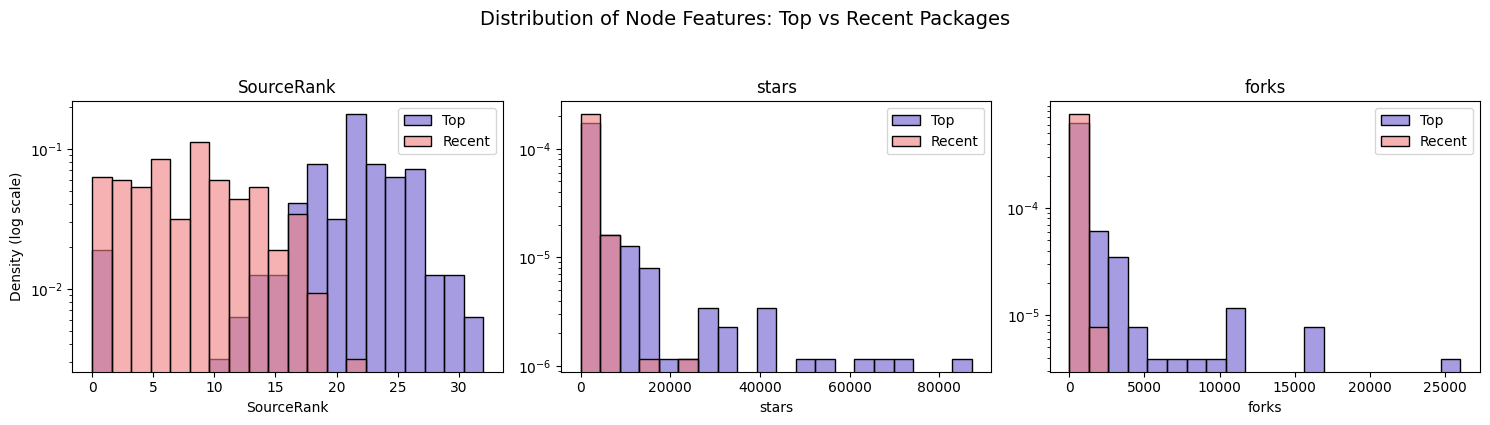

In [19]:
fig, axes = plt.subplots(1, 3, figsize=(15, 4))

features = ["SourceRank", "stars", "forks"]

for i, feature in enumerate(features):
    # Compute min and max for both datasets to get consistent bin edges
    data_top = df_nodes_top[feature]
    data_recent = df_nodes_recent[feature]
    data_all = pd.concat([data_top, data_recent])
    min_val = data_all.min()
    max_val = data_all.max()

    # Use 20 bins
    bin_width = (max_val - min_val) / 20 if max_val > min_val else 1
    bins = np.arange(min_val, max_val + bin_width, bin_width)

    sns.histplot(data_top, bins=bins, color=colors[0], label="Top", ax=axes[i], alpha=0.6, stat="density")
    sns.histplot(data_recent, bins=bins, color=colors[1], label="Recent", ax=axes[i], alpha=0.6, stat="density")
    axes[i].set_title(features[i])
    axes[i].set_xlabel(feature)
    axes[i].set_yscale("log")  # Set y-axis to log scale
    if i == 0:
        axes[i].set_ylabel("Density (log scale)")
    else:
        axes[i].set_ylabel("")
    axes[i].legend()

fig.suptitle("Distribution of Node Features: Top vs Recent Packages", fontsize=14, y=1.05)
plt.tight_layout()
plt.show()

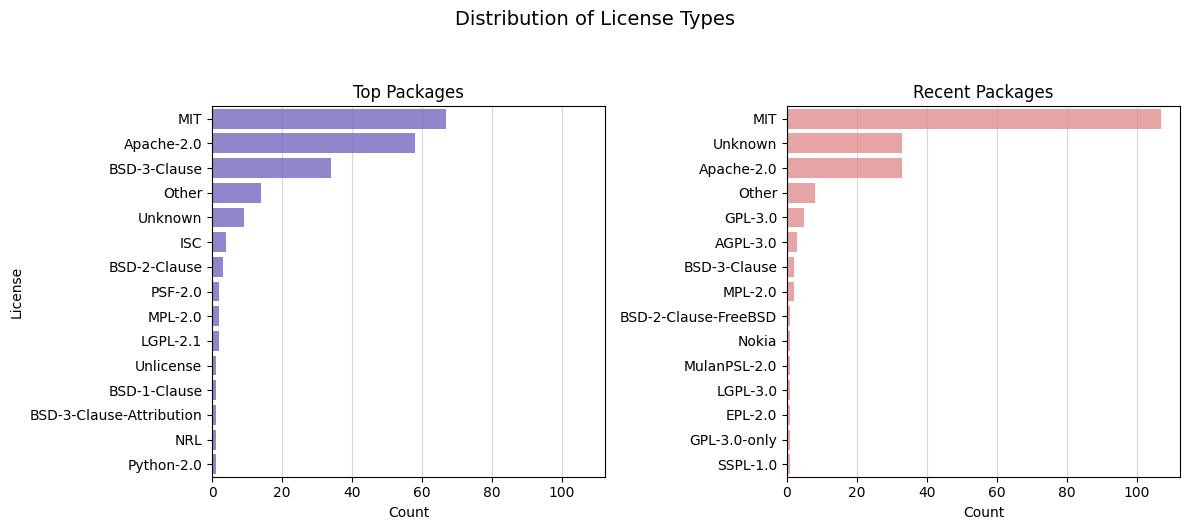

In [21]:
# Plot and compare license value counts for df_nodes_top and df_nodes_recent

fig, axes = plt.subplots(1, 2, figsize=(12, 5), sharex=True)

# Top packages
license_counts_top = df_nodes_top['license'].value_counts().sort_values(ascending=False)
sns.barplot(x=license_counts_top.values, y=license_counts_top.index, ax=axes[0], color=color_top, alpha=0.8)
axes[0].set_title("Top Packages")
axes[0].set_xlabel("Count")
axes[0].set_ylabel("License")

# Recent packages
license_counts_recent = df_nodes_recent['license'].value_counts().sort_values(ascending=False)
sns.barplot(x=license_counts_recent.values, y=license_counts_recent.index, ax=axes[1], color=color_recent, alpha=0.8)
axes[1].set_title("Recent Packages")
axes[1].set_xlabel("Count")
axes[1].set_ylabel("")

for ax in axes:
    add_grid(ax)

fig.suptitle("Distribution of License Types", fontsize=14, y=1.05)
plt.tight_layout()
plt.show()

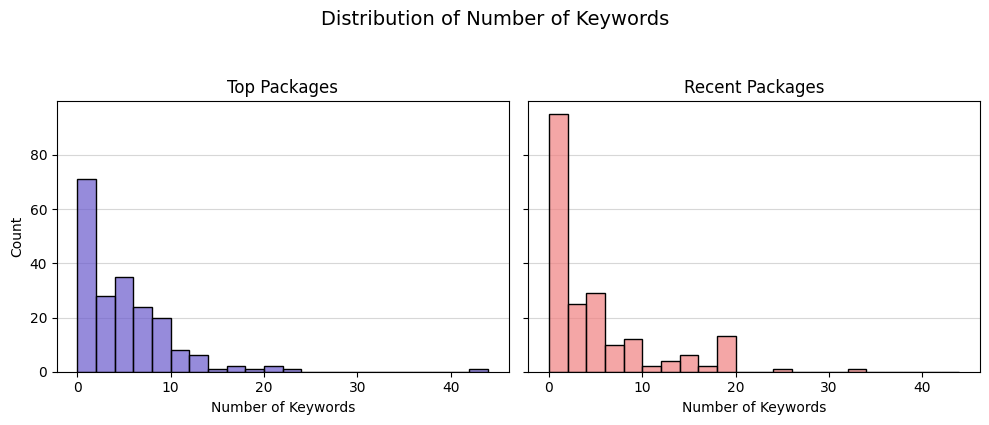

In [ ]:
fig, axes = plt.subplots(1, 2, figsize=(10, 4), sharey=True, sharex=True)

# Determine the global min and max for more uniform bins
min_kw = min(df_nodes_top['num_keywords'].min(), df_nodes_recent['num_keywords'].min())
max_kw = max(df_nodes_top['num_keywords'].max(), df_nodes_recent['num_keywords'].max())

# Use a fixed bin width for uniformity
bin_width = 2
bins = np.arange(min_kw, max_kw + bin_width + 1, bin_width)

# Top packages
sns.histplot(df_nodes_top['num_keywords'], bins=bins, 
             color=color_top, ax=axes[0], alpha=0.7)
axes[0].set_title("Top Packages")
axes[0].set_xlabel("Number of Keywords")
axes[0].set_ylabel("Count")

# Recent packages
sns.histplot(df_nodes_recent['num_keywords'], bins=bins, 
             color=color_recent, ax=axes[1], alpha=0.7)
axes[1].set_title("Recent Packages")
axes[1].set_xlabel("Number of Keywords")
axes[1].set_ylabel("")

for ax in axes:
    add_grid(ax, "y")

fig.suptitle("Distribution of Number of Keywords", fontsize=14, y=1.05)
plt.tight_layout()
plt.show()


**SourceRank Metrics**

**Copycats (Projects in Same Repo)**

In [14]:
df_nodes_recent.groupby("repo_url").size().sort_values(ascending=False).head(20)

repo_url
                                                                    59
https://github.com/traceloop/openllmetry                            13
Unknown                                                              3
https://github.com/openxla/xprof                                     2
https://github.com/BlueSpacePotato/speciallist                       1
https://codeberg.org/xasc/tree-sitter-t32.git                        1
https://bitbucket.org/tbint/tbint-logger-py                          1
https://github.com/CybercentreCanada/assemblyline-service-client     1
https://github.com/CybercentreCanada/assemblyline-service-server     1
https://github.com/CybercentreCanada/assemblyline-ui                 1
https://github.com/CybercentreCanada/assemblyline-v4-service         1
https://github.com/Davide-sd/sympy-plot-backends                     1
https://github.com/Digdgeo/Ndvi2Gif                                  1
https://github.com/CybercentreCanada/assemblyline-base              